# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Поиск ближайших соседей

## Общая информация

Дата выдачи: 07.06.2021

Мягкий дедлайн: 17.06.2021 05:59 MSK
Жёсткий дедлайн: 19.06.2021 05:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу — 13 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи

Задания сдаются через систему anytask. Посылка должна содержать:

* Ноутбук homework-practice-13-knn-Username.ipynb

Username — ваша фамилия на латинице.

---


В этом задании мы будем работать с датасетом [FashionMnist](https://github.com/zalandoresearch/fashion-mnist) изображений предметов одежды и обуви. В файле уже находится массив со 100 найденными соседями каждого тестового объекта по евклидовой метрике, однако мы для начала (чтобы реализовать метод случайных проекций) попробуем найти 100 ближайших соседей для каждого объекта по косинусной близости.

In [ ]:
! wget -nc -q http: // ann-benchmarks.com / fashion-mnist-784-euclidean.hdf5

In [1]:
import h5py


with h5py.File('fashion-mnist-784-euclidean.hdf5', 'r') as f:
    train = f['train'][()]
    test = f['test'][()]
    true_neighbors_eucl = f['neighbors'][()]

print(train.shape)
print(test.shape)
print(true_neighbors_eucl.shape)

(60000, 784)
(10000, 784)
(10000, 100)


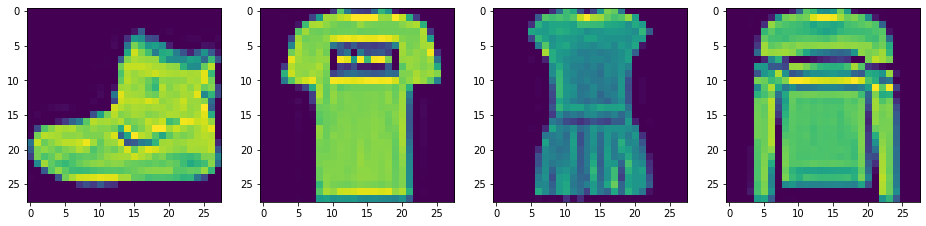

In [2]:
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 4))

plt.subplot(141)
plt.imshow(train[0].reshape(28, 28))

plt.subplot(142)
plt.imshow(train[1].reshape(28, 28))

plt.subplot(143)
plt.imshow(train[3].reshape(28, 28))

plt.subplot(144)
plt.imshow(train[5].reshape(28, 28))

plt.show()

В библиотеке `scikit-learn` есть модуль с алгоритмами поиска ближайших соседей, помогающий решать задачи классификации и регрессии. В этом задании, однако, нас будет интересовать не классификация, а качество и скорость решения непосредственно задачи поиска. Определим для этого две метрики:

* **Recall**: доля «настоящих соседей», которых нашёл алгоритм поиска. Пример: если вам необходимо найти 100 ближайших соседей, и из 100 возвращённых алгоритмом объектов 93 действительно находятся в множестве ближайших, то полнота равна 0.93.


* **Queries per second (QPS), также requests per second (RPS)**: число запросов, на которое алгоритм успевает ответить за одну секунду. Часто эту характеристику вычисляют как $\dfrac{num\_queries}{total\_time}$, где $num\_queries$ — общее число запросов, а $total\_time$ — суммарное время их выполнения; однако, так как некоторые реализации в задании умеют группировать запросы и выполнять несколько параллельно, мы будем осуществлять их по отдельности и усреднять величину $\dfrac{1}{request\_time}$.

Хотя в классе `NearestNeighbors` нет методов приближённого поиска ближайших соседей, мы воспользуемся им, чтобы найти 100 ближайших объектов по косинусной близости, сформировав таким образом правильные ответы для приближённых методов. Алгоритмы `kd_tree` и `ball_tree` в этом классе не поддерживают `metric=cosine`, поэтому распараллелим полный перебор:

In [ ]:
from sklearn.neighbors import NearestNeighbors


sklearn_index = NearestNeighbors(
    n_neighbors=100,
    algorithm='brute',
    metric='cosine',
    n_jobs=-1
)

sklearn_index.fit(train)

true_neighbors_cosine = sklearn_index.kneighbors(
    test,
    n_neighbors=100,
    return_distance=False
)

В ячейке ниже определяются гиперпараметры алгоритма LSH: размерность хэша (так как для каждой гиперплоскости мы храним только знак скалярного произведения, каждую координату можно представить одним битом) и число хэш-таблиц, а также создаётся массив гиперплоскостей для каждого бита в хэше и каждой таблицы.

In [ ]:
import numpy as np


np.random.seed(0x1ee7c0de)

NUM_TABLES = 20
NUM_BITS = 8

random_hyperplanes = np.random.randn(NUM_TABLES, NUM_BITS, train.shape[1]).astype(np.float32)

**Задание 1. (3 балла)**

Реализуйте на все методы класса `LSHIndex`, а затем постройте индекс по датасету `FashionMNIST` и подсчитайте recall вашего решения. Чтобы для удобства вместо косинусной близости считать скалярное произведение, и обучающую, и тестовую части датасета можно нормировать заранее.

In [ ]:
def compute_hashes(matrices, query):
    """
    Compute hash values for each hash table and a given vector.
    Args:
        matrices: np.array of shape (NUM_TABLES, NUM_BITS, dim), last axis represents
            random hyperplanes for each hash bit of each table
        query: vector to be hashed
    Returns:
        hashes: np.array of shape (NUM_TABLES, ), contains hash values for each table as unsigned integers
    """

    # YOUR CODE HERE

    raise NotImplementedError


class LSHIndex:

    def __init__(self, vectors, projection_matrices):
        """
        Build the index and store vectors for efficient neighbors search.
        Args:
            vectors: Training data, np.array (num_vectors, dim). Each k-NN query looks for neighbors in this set
            projection_matrices: np.array of shape (NUM_TABLES, NUM_BITS, dim), last axis represents
                random hyperplanes for each hash bit of each table
        """

        # YOUR CODE HERE

        raise NotImplementedError

    def query(self, query, k_neighbors):
        """
        A helper function to perform a k-NN query.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
        Returns:
            neighbors: a list of indices in the dataset
                used to build the index. Vectors at these positions represent approximate k nearest neighbors of
                the query, indices do not need to be sorted by any property
        """
        hashes = compute_hashes(np.asarray(self.matrices), query)

        return self._search_neighbors(query, k_neighbors, hashes)

    def _search_neighbors(self, query, k_neighbors, hashes):
        """
        All the fun happens here. Given a sample, its hashes and the number  of neighbors, locate nearest neighbors
            wrt cosine similarity using the hash tables built during index construction.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
            hashes: an array containing hash values of query for each hash table
        Returns:
            neighbors: a list of indices in the dataset
                used to build the index. Vectors at these positions represent approximate k nearest neighbors of
                the query, indices do not need to be sorted by any property
        """

        # YOUR CODE HERE

        raise NotImplementedError

Функции для подсчета нужных метрик

In [ ]:
from tqdm.auto import tqdm
from time import perf_counter


def compute_recall_qps(query_func: callable, test_set: np.ndarray, true_neighbors: np.ndarray, **kwargs):
    """
    Given a function that returns a list of nearest neighbors, estimate its recall and speed.
    Args:
        query_func: function with signature (query, k_neighbors, **kwargs).
            Returns a list of k_neighbors approximate nearest neighbors for a query
        test_set: array with shape (num_objects, dim). Contains query vectors for recall evaluation
        true_neighbors: array of indices with shape (num_objects, num_neighbors). Contains ground truth data for
            recall evaluation. k_neighbors from query_func is inferred from its shape
        **kwargs: passed to query_func
    Returns:
        avg_recall: average recall of query_func over the test set
        qps: number of queries per second handled by query_func 
    """
    recalls = []
    query_times = []

    for sample, neighbors_for_sample in zip(test_set, tqdm(true_neighbors)):
        start = perf_counter()

        approx_neighbors = query_func(sample, k_neighbors=neighbors_for_sample.shape[0], **kwargs)

        query_times.append(1 / (perf_counter() - start))

        set_true = set(neighbors_for_sample.tolist())
        hits = sum(1 for neighbor in approx_neighbors if neighbor in set_true)

        recalls.append(hits / len(set_true))

    return np.mean(recalls), np.mean(query_times)

In [ ]:
# YOUR CODE HERE

# recall, qps = ...

print(recall, qps)

assert recall >= 0.95

Визуализируйте пример работы алгоритма: найдите 5 ближайших соседей для нескольких объектов тестовой выборки и покажите, каким изображениям они соответствуют (вместе с самим запросом).

In [ ]:
# YOUR CODE HERE

**Задание 2. (2 балла)**

Исследуйте и покажите на графиках зависимость recall и QPS от размера хэша и числа хэш-таблиц. Сравните вашу реализацию с классом `sklearn.neighbors.NearestNeighbors`: так как для косинусной близости в этом классе поддерживается только `algorithm='brute'`, вы получите время работы точного поиска ближайших соседей. Для честности сравнения укажите в конструкторе метода `n_jobs` равным 1 и при замерах времени проводите поиск соседей для каждого объекта отдельно.

Отметьте соответствующую ему точку на графике recall-QPS, а затем с помощью перебора гиперпараметров LSH постройте кривую в этих координатах для вашей реализации (нужно протестировать хотя бы 5 различных комбинаций размера хэша и числа таблиц). При построении можете вдохновляться графиками с сайта [ann-benchmarks](http://ann-benchmarks.com/):

![](http://ann-benchmarks.com/fashion-mnist-784-euclidean_100_euclidean.png)

In [ ]:
# YOUR CODE HERE

**Задание 3. (2 балла)**

Ниже расположен шаблон класса `NSWIndex`, который реализует алгоритм [Navigable Small World](https://publications.hse.ru/mirror/pubs/share/folder/x5p6h7thif/direct/128296059). Реализуйте все его методы, а затем постройте индекс по датасету `FashionMNIST` и подсчитайте recall вашего решения.

In [ ]:
class NSWIndex:

    def __init__(self, vectors, num_neighbors, num_construction_runs):
        """
        Build the index and store vectors for efficient neighbors search.
        Args:
            vectors: Training data, np.array (num_vectors, dim). Each k-NN query looks for neighbors in this set
            num_neighbors: how many neighbors to look for during sequential insertion
            num_construction_runs: number of search attempts in k-NN search during construction
        """
        # YOUR CODE HERE

        raise NotImplementedError

    def query(self, query, k_neighbors, num_search_runs):
        """
        A helper function to perform a k-NN query. Used to ensure that _knn_search can be called with GIL lifted.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
            num_search_runs: number of search attempts (parameter m in the NSW paper)
        Returns:
            neighbors: a list of indices in the dataset used to build the index. Vectors at these positions
            represent approximate k nearest neighbors of the query, indices do not need to be sorted
        """
        return self._knn_search(query, k_neighbors, num_search_runs)

    def _knn_search(self, query, k_neighbors, num_search_runs):
        """
        Run the NSW search algorithm in a constructed graph.
        Args:
            query: a normalized query vector the neighbors of which we need to find
            k_neighbors: the number of neighbors to return
            num_search_runs: number of search attempts (parameter m in the NSW paper)
        Returns:
            neighbors: a list of indices in the dataset used to build the index. Vectors at these positions
            represent approximate k nearest neighbors of the query, indices do not need to be sorted
        """
        # YOUR CODE HERE

        raise NotImplementedError

**Задание 4. (1 балл)**

Сравните вашу реализацию с классом `sklearn.neighbors.NearestNeighbors` и `LSHIndex`, построив recall-QPS-кривые в зависимости от параметров `num_construction_runs` и `num_search_runs`.

In [ ]:
# YOUR CODE HERE

**Задание 5. (2 балла)**

Воспользуйтесь библиотекой `nmslib`, в которой есть эффективная реализация алгоритма HNSW. Постройте индекс для датасета и постройте аналогичную прошлым заданиям кривую recall-qps, варьируя параметры `efConstruction`, `M` и `efSearch`.

In [ ]:
# -_-)_／☆･ ･ ･ ‥……━━●~*

**Бонус. (3 балла)**

Реализуйте свою версию алгоритма SCANN (Scalable Approximate Nearest Neighbor). Сравните работу алгоритма с предыдущими методами, сделайте выводы о бесполезности происходящего.

In [ ]:
# YOUR CODE HERE